In [1]:
import numpy as np
import time
import numpy.linalg as npl
import scipy as sp
import scipy.sparse.linalg as spspl
import matplotlib.pyplot as plt
%pylab inline
from dolfin import *

Populating the interactive namespace from numpy and matplotlib


## Définition des classes et paramètres

In [127]:
# Rayon du disque
r = 0.3

# Nombre de noeuds
N = 20

# Classes des domaines
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0)
class Gamma0(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2 and (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2

# Initialize sub-domain instances
left   = Left()
top    = Top()
right  = Right()
bottom = Bottom()
gamma  = Gamma0()

# Define mesh
mesh = UnitSquareMesh(N,N)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)         #domains 0 = all space
gamma.mark(domains, 1)     #domains 1 = all gamma0

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) #1d domains
boundaries.set_all(0)      #boundaries 0 = all boundaries
left.mark(boundaries, 1)   #boundaries 1 = left (Neumann)
top.mark(boundaries, 2)    #boundaries 2 = top (Dirichlet)
right.mark(boundaries, 3)  #boundaries 3 = right (Neumann)
bottom.mark(boundaries, 4) #boundaries 4 = bottom (Neumann parametrized)

# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 0.0, boundaries, 2)]

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

## Solver du problème 2D

In [3]:
def Solver(mu):
    # Define input data
    mu0 = Constant(mu[0])  
    mu1 = Constant(mu[1])
    
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    def a1(mu0):
        return inner(mu0*grad(u),grad(v))*dx(1)
    a = a0 + a1(mu0) #+ inner(mu1*grad(u),grad(v))*ds(4)
    L0 = v*ds(4)
    L = mu1*L0
    
    # Passage en nd.array
    A = assemble(a)
    b = assemble(L)
    A2 = np.copy(A.array())
    b2 = np.copy(b.get_local())
    
    # Conditions de Dirichlet
    n=0
    niter=2
    for i in range((N+1)**2):
        for j in range((N+1)**2):
            if (i == n)and(i<=int((N+1)**2)/2):
                A2[i,:] = 0
                A2[i,i] = 1
                n += niter
                niter += 1
    
    # Résolution du système linéaire
    u2 = npl.solve(A2,b2)
    
    # Passage en dolfin.Function
    Sol = Function(V)
    Sol.vector().set_local(u2)
    #c = plot(Sol)
    #plt.colorbar(c)

    return np.array([Sol,A2,b2])

In [4]:
%%time
mu_test = np.array([8.5, 0.6666666666666665])
A = Solver(mu_test)[0]
B = []

CPU times: user 2.35 s, sys: 390 ms, total: 2.74 s
Wall time: 2.36 s


In [5]:
%%time
B = []
C = []
D = []
for i in range(5):
    A = Solver(mu_test)[0]
    B.append(A)
    C.append(A)
    D.append(A)
D = np.array(D)


CPU times: user 11.8 s, sys: 646 ms, total: 12.5 s
Wall time: 5.1 s


In [6]:
T0 = np.array([1,10,7])
T1 = np.array([-1,1,7])
MUs = training_set_creator(T0,T1)
print(MUs[40])

NameError: name 'training_set_creator' is not defined

In [ ]:
%%time
U1,A1,f1 = Solver(MUs[0])
U_delta_mu1 = U1.vector().get_local()
rang = np.array(np.arange(0,len(MUs),1),'int')
np.delete(rang,0)
U_delta_list = []
A_delta_list = []
f_delta_list = []
ehehglob = 0
for mu_loop in MUs:
    start_time = time.time()
    U,A,F = Solver(mu_loop)
    print("Temps du solver : " ,time.time()-start_time)
    eheh = time.time()
    A_delta_list.append(A)
    f_delta_list.append(F)
    U_delta_list.append(U.vector().get_local())
    ehehglob += time.time() - eheh

print("Append : ",ehehglob)
blabla = time.time()
U_delta = np.array(U_delta_list)
A_delta = np.array(A_delta_list)
F_delta = np.array(f_delta_list)
B = np.copy(np.array(U_delta_mu1)).reshape(len(np.array(U_delta_mu1)),1)
err = 1e10
n=1 
conv = []
print("Ptit bout à la fin : ",time.time()-blabla)

Temps du solver :  1.0043184757232666
Temps du solver :  0.9331655502319336
Temps du solver :  0.9448482990264893
Temps du solver :  0.9469733238220215
Temps du solver :  0.9523262977600098
Temps du solver :  0.944793701171875
Temps du solver :  0.940706729888916
Temps du solver :  0.9356775283813477
Temps du solver :  0.9645340442657471
Temps du solver :  0.9442675113677979
Temps du solver :  0.9404840469360352
Temps du solver :  0.9998016357421875
Temps du solver :  0.9352877140045166
Temps du solver :  1.0653972625732422
Temps du solver :  1.0537002086639404
Temps du solver :  0.9587769508361816
Temps du solver :  0.961836576461792
Temps du solver :  1.0121898651123047
Temps du solver :  0.939894437789917
Temps du solver :  0.940159797668457
Temps du solver :  1.1887500286102295
Temps du solver :  1.0994203090667725
Temps du solver :  0.9953539371490479
Temps du solver :  0.9968569278717041
Temps du solver :  0.945380687713623
Temps du solver :  0.9412028789520264
Temps du solver : 

## Offline procedure

In [5]:
def greedy_algorithm2(MUs, solver=Solver, tol=1e-5, N=7):
    start_time = time.time()
    # On prend un mu (au hasard) pour initialiser l'algorithme
    #mu_1 = MUs[0]
    #np.delete(MUs, 0)
    U1,A1,f1 = solver(MUs[0])
    U_delta_mu1 = U1.vector().get_local()
    #U_delta_list = []
    #for mu_loop in training_set:
    #        U_delta_list.append(solver(mu_loop)[0].vector().get_local())
    #        print("itération")
    rang = np.array(np.arange(0,len(MUs),1),'int')
    np.delete(rang,0)
    # On calcule tous les u_delta pour éviter de le refaire dans la boucle par la suite
    U_DELTA = np.array([solver(MUs[i])[0].vector().get_local() for i in rang])
    
    # B est la matrice de changement de base de A_delta à A_rb
    U_delta = np.array(U_delta_mu1)
    B = np.copy(U_delta).reshape(len(U_delta),1)
    print("Temps d execution : %s secondes ---" % (time.time() - start_time))
    err = 1e10
    #print(np.shape(U_delta))
    n=1
    while err > tol and rang.shape[0] > 0 and n<N:
        
        eta = np.zeros(rang.shape[0])
        
        for idx_mu in rang:
            A_delta_mu = solver(MUs[idx_mu])[1]
            f_delta_mu = solver(MUs[idx_mu])[2]
        
            u_delta_mu = U_DELTA[idx_mu]
            
            # A_rb_mu @ u_rb_mu = f_rb_mu
            # A_rb_mu = B.T @ A_delta_mu @ B
            print("A    : ",np.shape(A_delta_mu))
            print("b    : ",np.shape(f_delta_mu))
            print("Base : ",np.shape(B))
            u_rb_mu = npl.solve(B.T.dot(A_delta_mu.dot(B)), B.T.dot(f_delta_mu))
            
            # Pour l'instant, eta(mu) = ||u_delta - u_rb||_L2
            eta[idx_mu] = npl.norm(u_delta_mu - B.dot(u_rb_mu), ord=2)
        
        print("ici")
        # On cherche la pire approximation
        idx_worst_mu = np.argmax(eta)
        
        add = np.array(U_DELTA[idx_worst_mu]).reshape(2601,1).T
        B = np.vstack((B.T,add/npl.norm(add))).T
        
        np.delete(rang, idx_worst_mu)
        np.delete(U_DELTA, idx_worst_mu)
        
        err = eta[idx_worst_mu]
        n+=1
        
    return B

In [64]:
A = np.zeros((4,2))
A[:,0] = [0,1,2,3]
A[:,1] = [5,6,7,8]
print(A)
A = np.delete(A,1,axis=1)
print(A)

[[0. 5.]
 [1. 6.]
 [2. 7.]
 [3. 8.]]
[[0.]
 [1.]
 [2.]
 [3.]]


In [122]:
def greedy_algorithm(MUs, solver=Solver, tol=1e-5, N=7):
    start_time = time.time()
    U,A,b=solver(MUs[0])
    U_delta_mu1 = U.vector().get_local()
    np.delete(MUs, 0)
    
    U_delta = np.zeros((len(U_delta_mu1),len(MUs)))
    A_delta = np.zeros((len(U_delta_mu1),len(U_delta_mu1),len(MUs)))
    F_delta = np.zeros((len(U_delta_mu1),len(MUs)))
    n = 0
    for mu_loop in MUs:
        U,A,F = Solver(mu_loop)
        A_delta[:,:,n] = A
        F_delta[:,n] = F
        U_delta[:,n] = U.vector().get_local()
        n+=1

    
        
    # B est la matrice de changement de base de A_delta à A_rb
    #U_delta = np.array(U_delta_mu1)
    B = np.copy(np.array(U_delta_mu1)).reshape(np.shape(np.array(U_delta_mu1))[0],1)
    print("Temps d execution : %s secondes ---" % (time.time() - start_time))
    err = 1e10
    conv = []
    n=1
    while err > tol and len(MUs) > 0 and n<N:
        print(f"Itération n°{n}")
        print("Erreur:", err)
        eta = np.zeros(len(MUs))
        for idx_mu, mu in enumerate(MUs):
            A_delta_mu = A_delta[:,:,idx_mu]
            f_delta_mu = F_delta[:,idx_mu]
            u_delta_mu = U_delta[:,idx_mu]
            u_rb_mu = npl.solve(B.T.dot(A_delta_mu.dot(B)), B.T.dot(f_delta_mu))
            # Pour l'instant, eta(mu) = ||u_delta - u_rb||_L2
            eta[idx_mu] = npl.norm(u_delta_mu - B.dot(u_rb_mu), ord=2)
        # On cherche la pire approximation
        idx_worst_mu = np.argmax(eta)
        add = np.zeros((len(U_delta),1))
        add[:,0] = np.copy(U_delta[:,idx_worst_mu])
        add = add.T
        B = np.vstack((B.T,add/npl.norm(add))).T
        MUs.pop(idx_worst_mu)
        np.delete(U_delta, idx_worst_mu,axis=1)
        err = eta[idx_worst_mu]
        conv += [err]
        n += 1
        print("Erreur : ",err)
    temps = time.time() - start_time
    return B,temps,conv, err

In [123]:
def greedy_algorithm4(MUs, solver=Solver, tol=1e-5, N=7):
    start_time = time.time()
    U1,A1,f1 = solver(MUs[0])
    U_delta_mu1 = U1.vector().get_local()
    rang = [int(i) for i in range(len(MUs))]
    U_delta_list = []
    A_delta_list = []
    f_delta_list = []
    for mu_loop in MUs:
        U,A,F = solver(mu_loop)
        A_delta_list.append(A)
        f_delta_list.append(F)
        U_delta_list.append(U.vector().get_local())
    B = np.copy(np.array(U_delta_mu1)).reshape(len(np.array(U_delta_mu1)),1)
    err = 1e10
    n=1 
    conv = []
    print(time.time()-start_time)
    start_time2 = time.time()
    while err > tol and len(rang) > 0 and n<N:  
        eta = np.zeros(len(rang))
        for i, idx_mu in enumerate(rang):
            A_delta_mu = A_delta_list[idx_mu]
            f_delta_mu = f_delta_list[idx_mu]
            u_delta_mu = U_delta_list[idx_mu]
            u_rb_mu = npl.solve(B.T.dot(A_delta_mu.dot(B)), B.T.dot(f_delta_mu))  
            # Pour l'instant, eta(mu) = ||u_delta - u_rb||_L2
            eta[i] = npl.norm(u_delta_mu - B.dot(u_rb_mu), ord=2)
        
        # On cherche la pire approximation
        idx_worst_mu = np.argmax(eta)
        add = np.array(U_delta_list[idx_worst_mu]).reshape(2601,1).T
        B = np.vstack((B.T,add/npl.norm(add))).T  
        del rang[idx_worst_mu]
        err = eta[idx_worst_mu]
        conv += [err]
        n+=1 
    print(time.time()-start_time2)
    temps = time.time() - start_time
    return B,temps,conv, err

In [124]:
def training_set_creator(*args):
    """
    args are a non-zero number of lists of size 3.
    Example of use: we want the creation of an iteratable representing all possible elements on a n-dimensional grid
    first dimension goes from a to b with c elements, then you pass "[a,b,c]" as a first argument.
    return: n-dimensional grid on which you can iterate.
    
    """
    linspace_args = (np.linspace(*arg) for arg in args)
    
    meshes = np.meshgrid(*linspace_args)
    dimensions = map(np.ravel, meshes)
#     dimensions = [mesh.ravel() for mesh in meshes]
    
    tuples = zip(*dimensions)
    return list(tuples)
#     for tup in tuples:
#         yield(tuple(tup))

In [125]:
def reduced_solver(mu,A_q,shape):
    """
    from output of pre_computer and a mu: computes A_rb and f_rb and u_rb, the solution of A_rb.u_rb=f_rb
    """
    A = np.copy(A_q[1])
    f = np.copy(A_q[3])
    for i in range(shape):
        A += A_q[0][i]*mu[i]
    for i in range(shape,len(mu)):
        f += A_q[2][i-shape]*mu[i]
    return npl.solve(A,f)

## Precomputer

In [126]:
def pre_computer(Base):
    """
    pre_computer take as input a reduced_base and pre_computes all quantities used for a reduced_solver.
    output: [[A_rb^q](0<= i <=n1),A_rb^0,[f_rb^q](0<= i <=n2),f_rb^0],n
    with A_rb = sum_(i in 0..n1){ mu[i]*A_rb^(q_1)_i } + A_rb^0
    and  f_rb = sum_(i in n1+1..n2){ mu[i]*f_rb^(q_1)_i } + f_rb^0
            n = n1+1
    """
    #mu0 = Constant(mu[0])
    #mu1 = Constant(mu[1])
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    #def a1(mu0):
    #    return inner(grad(u),grad(v))*dx(1)
    a1 = inner(grad(u),grad(v))*dx(1)

    L0 = v*ds(4)
    #L = mu1*L0
    
    A_0M = assemble(a0)
    A_1M = assemble(a1)
    b = assemble(L0)
    A_0 = np.copy(A_0M.array())
    A_1 = np.copy(A_1M.array())
    b_0 = np.copy(b.get_local())
    #n=0
    #niter=2
    #for i in range((N+1)**2):
    #    for j in range((N+1)**2):
    #        if (i == n)and(i<=int((N+1)**2)/2):
    #            A_0[i,:] = 0
    #            A_0[i,i] = 1
    #            n += niter
    #            niter += 1
                
    A0B = [Base.T.dot(A_1.dot(Base))]
    A1B = Base.T.dot(A_0.dot(Base))
    b1 = [Base.T.dot(b_0)]
    b2 = Base.T.dot(np.zeros(b_0.shape))
    
    #At = assemble(a0 + a1(mu0))
    #bt = assemble(L)
    #A = np.copy(At.array())
    #b = np.copy(bt.get_local())
    
    return [A0B,A1B,b1,b2],1 #[Base.T.dot(A.dot(Base)),Base.T.dot(b)],1

## Résolution

In [87]:
%%time
T0 = np.array([1,10,10])
T1 = np.array([-1,1,10])
training_set = training_set_creator(T0,T1)
Base, temps, conv, err = greedy_algorithm(training_set,N=2)

Temps d execution : 140.77736258506775 secondes ---
Itération n°1
Erreur: 10000000000.0
Erreur :  9.71636458862679
CPU times: user 4min 53s, sys: 22.2 s, total: 5min 15s
Wall time: 2min 35s


In [88]:
print(Base.shape)
print(temps)
print(err)

(2601, 2)
154.93449521064758
9.71636458862679


### Création de la base

In [50]:
onl_err_mean = []
onl_err_max = []
onl_err_med = []
onl_tps_mean = []
onl_tps_max = []
onl_tps_med = []
temps_base = []
err_base = []
nb_vecteurs_base = []

for i in [4,5,6,7,8,9,10]:
    print(i)
    T0 = np.array([1,10,3])
    T1 = np.array([-1,1,3])
    training_set = training_set_creator(T0,T1)
    Base, temps, conv, err = greedy_algorithm(training_set,N=i)
    nb_vecteurs_base += [Base.shape[1]]
    temps_base += [temps]
    err_base += [err]
    A_q,shape = pre_computer(Base)
    T0 = np.array([1,10,10])
    T1 = np.array([-1,1,10])
    eval_set  = training_set_creator(T0,T1)
    errors = []
    times = []
    for mu in eval_set:
        U_true = Solver(mu)[0]
        start_time = time.time()
        U_rb = reduced_solver(mu,A_q,shape)
        times += [time.time() - start_time]
        print(times[-1])
        RES = Base.dot(U_rb)
        errors += [(npl.norm(U_true.vector().get_local()-RES))/npl.norm(U_true.vector())]
    onl_err_mean += [np.mean(errors)]
    onl_err_max += [np.max(errors)]
    onl_err_med +=[np.median(errors)]
    onl_tps_mean += [np.mean(times)]
    onl_tps_max += [np.max(times)]
    onl_tps_med += [np.median(times)]

4
0.00015401840209960938
0.00014925003051757812
0.0001513957977294922
0.000152587890625
0.0001533031463623047
0.00016021728515625
0.00015592575073242188
0.00015115737915039062
0.00017261505126953125
0.00015211105346679688
0.0001537799835205078
0.0001533031463623047
0.0001494884490966797
0.00015091896057128906
0.00015020370483398438
0.00015234947204589844
0.0001513957977294922
0.00015163421630859375
0.00015354156494140625
0.00015544891357421875
0.00015234947204589844
0.0001583099365234375
0.0001533031463623047
0.000152587890625
0.00015044212341308594
0.0001506805419921875
0.00016045570373535156
0.0001575946807861328
0.0001728534698486328
0.00015211105346679688
0.0001518726348876953
0.00015234947204589844
0.00015091896057128906
0.0001513957977294922
0.00015020370483398438
0.00015282630920410156
0.00015401840209960938
0.0001506805419921875
0.00015401840209960938
0.00016427040100097656
0.00014901161193847656
0.00016045570373535156
0.00016260147094726562
0.0001609325408935547
0.000168323516

0.0001556873321533203
0.0001518726348876953
0.0001533031463623047
0.00015592575073242188
0.00015306472778320312
0.0001556873321533203
0.00015425682067871094
0.00015592575073242188
0.00015306472778320312
0.0001513957977294922
0.00016736984252929688
0.00015163421630859375
0.0001537799835205078
0.000152587890625
0.00019621849060058594
0.00015401840209960938
0.00015306472778320312
0.00015282630920410156
0.00015306472778320312
0.00015044212341308594
0.00015354156494140625
0.00016736984252929688
0.0001621246337890625
0.0001556873321533203
0.00015211105346679688
0.00015544891357421875
0.00015234947204589844
0.0001513957977294922
0.0001533031463623047
0.00015115737915039062
0.00015306472778320312
0.0001513957977294922
0.00015163421630859375
0.00015234947204589844
0.00015234947204589844
0.00015282630920410156
8
0.0001628398895263672
0.0001704692840576172
0.00019669532775878906
0.00016641616821289062
0.00015234947204589844
0.0001518726348876953
0.00015234947204589844
0.00015544891357421875
0.000

In [51]:
print(onl_err_mean)
print(onl_err_max)
print(onl_err_med)
print(onl_tps_mean)
print(onl_tps_max)
print(onl_tps_med)
print(temps_base)
print(err_base)
print(nb_vecteurs_base)


[3.750737508189145e-05, 3.750737508189145e-05, 3.750737508189145e-05, 3.750737508189145e-05, 3.750737508189145e-05]
[0.0001681300419819594, 0.0001681300419819594, 0.0001681300419819594, 0.0001681300419819594, 0.0001681300419819594]
[1.2264392292776578e-05, 1.2264392292776578e-05, 1.2264392292776578e-05, 1.2264392292776578e-05, 1.2264392292776578e-05]
[0.00015686511993408204, 0.0001820087432861328, 0.00015691280364990234, 0.00015540599822998048, 0.00015653371810913085]
[0.00019359588623046875, 0.0005774497985839844, 0.00020313262939453125, 0.00019621849060058594, 0.00019669532775878906]
[0.00015401840209960938, 0.00016498565673828125, 0.00015401840209960938, 0.00015306472778320312, 0.0001533031463623047]
[17.08800435066223, 14.37278962135315, 14.4371018409729, 14.465577602386475, 15.04682445526123]
[5.251490734536987e-13, 5.251490734536987e-13, 5.251490734536987e-13, 5.251490734536987e-13, 5.251490734536987e-13]
[4, 4, 4, 4, 4]


In [43]:
%%time
T0 = np.array([1,10,3])
T1 = np.array([-1,1,3])
training_set = training_set_creator(T0,T1)
Base, temps, conv, err = greedy_algorithm(training_set,N=3)

CPU times: user 40 s, sys: 1.95 s, total: 42 s
Wall time: 14 s


In [44]:
print(temps)
print(conv)
print(err)
print(Base.shape)

13.951589345932007
[9.71636458862679, 0.011542527436926428]
0.011542527436926428
(2601, 3)


### Truth solution for mu_test & évaluation du temps mis

In [80]:
%%time
A_q,shape = pre_computer(Base)

CPU times: user 210 ms, sys: 95.8 ms, total: 306 ms
Wall time: 721 ms


In [46]:
T0 = np.array([1,10,10])
T1 = np.array([-1,1,10])
eval_set  = training_set_creator(T0,T1)
errors = []
times = []
for mu in eval_set:
    U_true = Solver(mu)[0]
    start_time = time.time()
    U_rb = reduced_solver(mu,A_q,shape)
    times += [time.time() - start_time]
    print(times[-1])
    RES = Base.dot(U_rb)
    errors += [(npl.norm(U_true.vector().get_local()-RES))/npl.norm(U_true.vector())]
print("Mean   : ", np.mean(errors))
print("Max    : ", np.max(errors))
print("Median : ", np.median(errors))
print("Mean   : ", np.mean(times))
print("Max    : ", np.max(times))
print("Median : ", np.median(times))

0.00015282630920410156
0.000152587890625
0.0001533031463623047
0.00015497207641601562
0.00015473365783691406
0.00017690658569335938
0.0001685619354248047
0.0001537799835205078
0.000164031982421875
0.00016021728515625
0.00016069412231445312
0.00015425682067871094
0.00015354156494140625
0.00018787384033203125
0.0001552104949951172
0.0001552104949951172
0.00015282630920410156
0.00016427040100097656
0.0001552104949951172
0.00015807151794433594
0.00015544891357421875
0.000217437744140625
0.0002238750457763672
0.00015687942504882812
0.00015807151794433594
0.0001544952392578125
0.0001556873321533203
0.0001556873321533203
0.000164031982421875
0.0001556873321533203
0.00015854835510253906
0.0001823902130126953
0.00016045570373535156
0.00020503997802734375
0.0001811981201171875
0.00017380714416503906
0.0061838626861572266
0.0001838207244873047
0.0001957416534423828
0.0001761913299560547
0.00026869773864746094
0.00015473365783691406
0.00016355514526367188
0.00015592575073242188
0.00015878677368164

In [35]:
print("Mean   : ", np.mean(errors))
print("Max    : ", np.max(errors))
print("Median : ", np.median(errors))

Mean   :  0.29761408350532365
Max    :  0.5286617675609915
Median :  0.3269408035978465


In [105]:
mu_test = np.array([30,3])

In [112]:
%%timeit

U_true = Solver(mu_test)[0]

1.02 s ± 7.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Online procedure ne dépendant pas de mu

In [107]:
%%time
A_q,shape = pre_computer(Base)

CPU times: user 162 ms, sys: 83.2 ms, total: 245 ms
Wall time: 167 ms


### Résolution en base réduite & évaluation du temps

In [116]:
U_rb = reduced_solver(mu_test,A_q,shape)

(2601,)


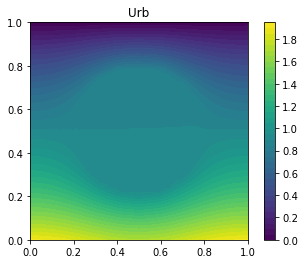

In [117]:
RES = Base.dot(U_rb)
print(np.shape(RES))
urb = Function(V)
urb.vector().set_local(RES)
e = plot(urb)
plt.title('Urb')
plt.colorbar(e)
plt.show()

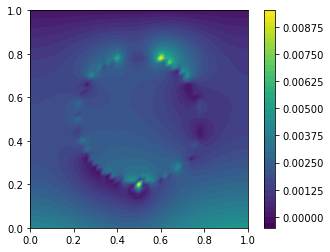

In [118]:
f = plot(abs(urb-U_true))
plt.colorbar(f)
plt.show()

In [119]:

U_true = Solver(np.array([30,3]))[0]

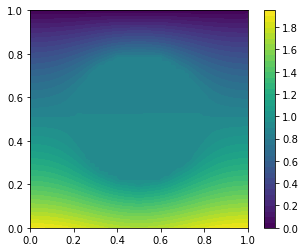

In [120]:
c = plot(U_true)
plt.colorbar(c)
plt.show()

In [121]:
RES = Base.dot(U_rb)
print(np.shape(RES))

#utmp = Function(V)
#a = plot(utmp)
#utmp.vector().set_local(RES)
#a = plot(utmp)
#plt.colorbar(a)
#plt.title("Urb")
#plt.show()



#plt.plot(X,Base.dot(U_rb),label="reduced_sol")
#plt.legend()
#plt.show()
udiff = Function(V)
udiff = U_true.vector() - urb.vector()
#print(norm(udiff))  ## NORME FENICS
print((npl.norm(U_true.vector().get_local()-RES))/npl.norm(U_true.vector().get_local()))

(2601,)
0.002097050144308003


In [30]:
%%time
T0 = np.array([1,10,9])
T1 = np.array([-1,1,9])
training_set = training_set_creator(T0,T1)
test = np.zeros((10,2))
for i in range(10):
    test[i] = np.copy([0.1 + i*0.99,-1 + i* 0.2])
Base = greedy_algorithm(training_set,tol=0.001)

Temps d execution : 83.88369107246399 secondes ---
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601,